In [1]:
# CELL 0: Setup & imports
import os, random, math, time, json
from pathlib import Path
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, brier_score_loss
import joblib

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

INPUT_DIR = "/kaggle/input/afml-proj"
WORK_DIR = "/kaggle/working"
os.makedirs(WORK_DIR, exist_ok=True)

STATIC_CSV = os.path.join(INPUT_DIR, "static_features_final.csv")
TEMP_CSV   = os.path.join(INPUT_DIR, "temporal_embeddings_predictions.csv")
CLIN_CSV   = os.path.join(INPUT_DIR, "clinical_embeddings.csv")
RAD_CSV    = os.path.join(INPUT_DIR, "radiology_embeddings.csv")
MERGED_PATH = os.path.join(WORK_DIR, "merged_fusion_table.csv")

LABEL_COL = "ventilation_within_12h"


Device: cuda


In [2]:
# ======================================================
# CELL 1: Load and merge modality CSVs (with ID normalization & clinical scaling)
# ======================================================

def safe_read(path):
    print(f"Reading: {path}")
    return pd.read_csv(path, low_memory=False)

# Remove old merged file so a fresh merge runs
if os.path.exists(MERGED_PATH):
    os.remove(MERGED_PATH)
    print(f"Deleted old merged table: {MERGED_PATH}")

# ------------------------------------------------------
# If merged table already exists, reuse it
# ------------------------------------------------------
if os.path.exists(MERGED_PATH):
    merged = safe_read(MERGED_PATH)
    print("Loaded existing merged table:", MERGED_PATH, merged.shape)

else:
    # ---- Load raw modality CSVs ----
    static_df = safe_read(STATIC_CSV)
    temp_df   = safe_read(TEMP_CSV)
    clin_df   = safe_read(CLIN_CSV)
    rad_df    = safe_read(RAD_CSV)

    # ------------------------------------------------------
    # 🔧 Normalize IDs consistently across all sources
    # ------------------------------------------------------
    def normalize_id(col):
        """Standardize subject_id or stay_id across all sources."""
        return (
            col.astype(str)
            .str.strip()
            .str.replace(".0", "", regex=False)
            .str.lstrip("0")
            .str.replace(" ", "", regex=False)
        )

    for d in (static_df, temp_df, clin_df, rad_df):
        for id_col in ['subject_id', 'stay_id']:
            if id_col in d.columns:
                d[id_col] = normalize_id(d[id_col])

    # ------------------------------------------------------
    # 🧩 Fix clinical embedding scale mismatch (normalize numeric columns)
    # ------------------------------------------------------
    if 'subject_id' in clin_df.columns:
        numeric_cols = [c for c in clin_df.columns if np.issubdtype(clin_df[c].dtype, np.number)]
        max_val = clin_df[numeric_cols].abs().max().max()
        clin_df[numeric_cols] = clin_df[numeric_cols] / max_val
        print(f"Scaled clinical embeddings to range roughly [-1,1] using max={max_val:.2f}")

    # ------------------------------------------------------
    # 🔗 Merge all modalities
    # ------------------------------------------------------

    # ---- Merge stay-level temporal embeddings ----
    print("Merging temporal embeddings by stay_id ...")
    merged = static_df.merge(temp_df, how='left', on='stay_id', suffixes=('', '_temp'))

    # ---- Merge subject-level clinical embeddings ----
    if 'subject_id' in clin_df.columns:
        print("Aggregating clinical embeddings per subject_id (mean pooling) ...")
        clin_agg = clin_df.groupby('subject_id').mean(numeric_only=True).reset_index()
        merged = merged.merge(clin_agg, how='left', on='subject_id', suffixes=('', '_clin'))

    # ---- Merge subject-level radiology embeddings ----
    if 'subject_id' in rad_df.columns:
        print("Aggregating radiology embeddings per subject_id (mean pooling) ...")
        rad_agg = rad_df.groupby('subject_id').mean(numeric_only=True).reset_index()
        merged = merged.merge(rad_agg, how='left', on='subject_id', suffixes=('', '_rad'))

    # ---- Debug: check ID overlap ----
    common_ids = len(set(static_df['subject_id']).intersection(set(rad_df['subject_id'])))
    print(f"Common subject_ids between static & radiology: {common_ids} / {len(static_df)}")

    merged.to_csv(MERGED_PATH, index=False)
    print(f"Merged saved to: {MERGED_PATH} shape: {merged.shape}")

# ------------------------------------------------------
# Detect embedding column blocks automatically
# ------------------------------------------------------
all_cols = merged.columns.tolist()

temporal_cols = [c for c in all_cols if c.startswith('emb_') or 
                 c.startswith('trans_enc_emb_') or c.startswith('temporal_emb_')]
if len(temporal_cols) == 0:
    numeric_cols = [c for c in all_cols if np.issubdtype(merged[c].dtype, np.number)]
    if len(numeric_cols) > 200:
        temporal_cols = numeric_cols[-128:]

clin_cols = [c for c in all_cols if c.startswith('clin_') or 
             c.startswith('clinical_') or c.startswith('disch_')]
rad_cols  = [c for c in all_cols if c.startswith('rad_') or 
             c.startswith('radiology_')]

if len(clin_cols) == 0 or len(rad_cols) == 0:
    numeric_cols = [c for c in all_cols if np.issubdtype(merged[c].dtype, np.number) 
                    and c not in temporal_cols and c != 'ventilation_within_12h']
    if len(numeric_cols) >= 1500:
        clin_cols = numeric_cols[:768]
        rad_cols  = numeric_cols[768:1536]

temporal_cols = sorted(list(set(temporal_cols)))
clin_cols     = sorted(list(set(clin_cols)))
rad_cols      = sorted(list(set(rad_cols)))

print(f"Detected counts → temporal: {len(temporal_cols)} | clinical: {len(clin_cols)} | radiology: {len(rad_cols)}")
static_sample = [c for c in merged.columns if c not in temporal_cols + clin_cols + rad_cols][:20]
print("Sample static cols:", static_sample)

# ------------------------------------------------------
# Coverage checks
# ------------------------------------------------------
def check_presence(df, cols, name):
    if len(cols) == 0:
        print(f"{name}: 0 columns detected.")
        return
    frac_present = (df[cols].abs().sum(axis=1) > 0).mean()
    print(f"{name} embeddings present fraction: {frac_present:.3f}")

check_presence(merged, temporal_cols, "Temporal")
check_presence(merged, clin_cols, "Clinical")
check_presence(merged, rad_cols,  "Radiology")


Reading: /kaggle/input/afml-proj/static_features_final.csv
Reading: /kaggle/input/afml-proj/temporal_embeddings_predictions.csv
Reading: /kaggle/input/afml-proj/clinical_embeddings.csv
Reading: /kaggle/input/afml-proj/radiology_embeddings.csv
Scaled clinical embeddings to range roughly [-1,1] using max=9.64
Merging temporal embeddings by stay_id ...
Aggregating clinical embeddings per subject_id (mean pooling) ...
Aggregating radiology embeddings per subject_id (mean pooling) ...
Common subject_ids between static & radiology: 3486 / 8274
Merged saved to: /kaggle/working/merged_fusion_table.csv shape: (8274, 1691)
Detected counts → temporal: 128 | clinical: 768 | radiology: 768
Sample static cols: ['subject_id', 'stay_id', 'gender', 'first_careunit', 'ventilation_within_12h', 'subject_id_temp', '747_rad', '748_rad', '749_rad', '750_rad', '751_rad', '752_rad', '753_rad', '754_rad', '755_rad', '756_rad', '757_rad', '758_rad', '759_rad', '760_rad']
Temporal embeddings present fraction: 0.9

In [3]:
# CELL 2: Preprocessing & train/val/test splits
df = merged.copy()
for c in ['subject_id','stay_id']:
    if c in df.columns: df[c] = df[c].astype(str)

if LABEL_COL not in df.columns:
    raise KeyError(f"Label {LABEL_COL} missing in merged table")

# identify static numeric & categorical columns
exclude = set(temporal_cols + clin_cols + rad_cols + ['subject_id','stay_id', LABEL_COL])
numeric_static = [c for c in df.columns if c not in exclude and np.issubdtype(df[c].dtype, np.number)]
cat_static = [c for c in df.columns if c not in exclude and not np.issubdtype(df[c].dtype, np.number)]
print("Numeric static:", numeric_static[:20])
print("Categorical static:", cat_static[:10])

# fill embedding NaNs with zeros
if len(temporal_cols)>0: df[temporal_cols] = df[temporal_cols].fillna(0.0)
if len(clin_cols)>0: df[clin_cols] = df[clin_cols].fillna(0.0)
if len(rad_cols)>0: df[rad_cols] = df[rad_cols].fillna(0.0)

df['has_temporal'] = (df[temporal_cols].abs().sum(axis=1) > 0).astype(int) if len(temporal_cols)>0 else 0
df['has_clinical'] = (df[clin_cols].abs().sum(axis=1) > 0).astype(int) if len(clin_cols)>0 else 0
df['has_radiology'] = (df[rad_cols].abs().sum(axis=1) > 0).astype(int) if len(rad_cols)>0 else 0

# subject-level split to prevent leakage
sub_label = df.groupby('subject_id')[LABEL_COL].max().reset_index().rename(columns={LABEL_COL:'subject_label'})
train_sub, test_sub = train_test_split(sub_label, test_size=0.2, random_state=SEED, stratify=sub_label['subject_label'])
train_sub, val_sub = train_test_split(train_sub, test_size=0.1111, random_state=SEED, stratify=train_sub['subject_label'])

train_df = df[df['subject_id'].isin(train_sub['subject_id'])]
val_df   = df[df['subject_id'].isin(val_sub['subject_id'])]
test_df  = df[df['subject_id'].isin(test_sub['subject_id'])]
print("Sizes (stays):", len(train_df), len(val_df), len(test_df))

# standardize numeric statics
scaler = StandardScaler()
if len(numeric_static)>0:
    scaler.fit(train_df[numeric_static].fillna(0.0).values)
    X_train_num = scaler.transform(train_df[numeric_static].fillna(0.0).values).astype(np.float32)
    X_val_num = scaler.transform(val_df[numeric_static].fillna(0.0).values).astype(np.float32)
    X_test_num = scaler.transform(test_df[numeric_static].fillna(0.0).values).astype(np.float32)
else:
    X_train_num = np.zeros((len(train_df),0),dtype=np.float32)
    X_val_num = np.zeros((len(val_df),0),dtype=np.float32)
    X_test_num = np.zeros((len(test_df),0),dtype=np.float32)

# categorical one-hot
if len(cat_static)>0:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(train_df[cat_static].fillna("NA"))
    X_train_cat = ohe.transform(train_df[cat_static].fillna("NA")).astype(np.float32)
    X_val_cat = ohe.transform(val_df[cat_static].fillna("NA")).astype(np.float32)
    X_test_cat = ohe.transform(test_df[cat_static].fillna("NA")).astype(np.float32)
else:
    X_train_cat = np.zeros((len(train_df),0),dtype=np.float32)
    X_val_cat = np.zeros((len(val_df),0),dtype=np.float32)
    X_test_cat = np.zeros((len(test_df),0),dtype=np.float32)

X_train_static = np.hstack([X_train_num, X_train_cat]).astype(np.float32)
X_val_static = np.hstack([X_val_num, X_val_cat]).astype(np.float32)
X_test_static = np.hstack([X_test_num, X_test_cat]).astype(np.float32)

# embeddings arrays
X_train_temp = train_df[temporal_cols].values.astype(np.float32) if len(temporal_cols)>0 else np.zeros((len(train_df),0),dtype=np.float32)
X_val_temp = val_df[temporal_cols].values.astype(np.float32) if len(temporal_cols)>0 else np.zeros((len(val_df),0),dtype=np.float32)
X_test_temp = test_df[temporal_cols].values.astype(np.float32) if len(temporal_cols)>0 else np.zeros((len(test_df),0),dtype=np.float32)

X_train_clin = train_df[clin_cols].values.astype(np.float32) if len(clin_cols)>0 else np.zeros((len(train_df),0),dtype=np.float32)
X_val_clin = val_df[clin_cols].values.astype(np.float32) if len(clin_cols)>0 else np.zeros((len(val_df),0),dtype=np.float32)
X_test_clin = test_df[clin_cols].values.astype(np.float32) if len(clin_cols)>0 else np.zeros((len(test_df),0),dtype=np.float32)

X_train_rad = train_df[rad_cols].values.astype(np.float32) if len(rad_cols)>0 else np.zeros((len(train_df),0),dtype=np.float32)
X_val_rad = val_df[rad_cols].values.astype(np.float32) if len(rad_cols)>0 else np.zeros((len(val_df),0),dtype=np.float32)
X_test_rad = test_df[rad_cols].values.astype(np.float32) if len(rad_cols)>0 else np.zeros((len(test_df),0),dtype=np.float32)

y_train = train_df[LABEL_COL].astype(int).values
y_val = val_df[LABEL_COL].astype(int).values
y_test = test_df[LABEL_COL].astype(int).values

# presence masks
has_train_temp = train_df['has_temporal'].astype(int).values
has_train_clin = train_df['has_clinical'].astype(int).values
has_train_rad = train_df['has_radiology'].astype(int).values

joblib.dump({'scaler':scaler, 'ohe': (ohe if len(cat_static)>0 else None),
             'numeric_static': numeric_static, 'cat_static': cat_static,
             'temporal_cols': temporal_cols, 'clin_cols': clin_cols, 'rad_cols': rad_cols},
            os.path.join(WORK_DIR,"fusion_preprocessors.pkl"))
print("Saved preprocessors to", os.path.join(WORK_DIR,"fusion_preprocessors.pkl"))


Numeric static: ['747_rad', '748_rad', '749_rad', '750_rad', '751_rad', '752_rad', '753_rad', '754_rad', '755_rad', '756_rad', '757_rad', '758_rad', '759_rad', '760_rad', '761_rad', '762_rad', '763_rad', '764_rad', '765_rad', '766_rad']
Categorical static: ['gender', 'first_careunit', 'subject_id_temp']


/tmp/ipykernel_39/1753479602.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['has_temporal'] = (df[temporal_cols].abs().sum(axis=1) > 0).astype(int) if len(temporal_cols)>0 else 0
/tmp/ipykernel_39/1753479602.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['has_clinical'] = (df[clin_cols].abs().sum(axis=1) > 0).astype(int) if len(clin_cols)>0 else 0
/tmp/ipykernel_39/1753479602.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Sizes (stays): 5940 736 1598


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Saved preprocessors to /kaggle/working/fusion_preprocessors.pkl


In [4]:
# CELL 3: Dataset and DataLoader with modality dropout
class FusionDataset(Dataset):
    def __init__(self, X_static, X_temp, X_clin, X_rad, y, has_temp=None, has_clin=None, has_rad=None, modal_dropout_p=0.0):
        self.X_static = X_static
        self.X_temp = X_temp
        self.X_clin = X_clin
        self.X_rad = X_rad
        self.y = y
        self.modal_dropout_p = modal_dropout_p
        self.has_temp = has_temp if has_temp is not None else (np.abs(X_temp).sum(axis=1)>0).astype(int)
        self.has_clin = has_clin if has_clin is not None else (np.abs(X_clin).sum(axis=1)>0).astype(int)
        self.has_rad  = has_rad  if has_rad  is not None else (np.abs(X_rad).sum(axis=1)>0).astype(int)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        s = self.X_static[idx] if self.X_static.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        t = self.X_temp[idx] if self.X_temp.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        c = self.X_clin[idx] if self.X_clin.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        r = self.X_rad[idx] if self.X_rad.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        has_t,has_c,has_r = int(self.has_temp[idx]), int(self.has_clin[idx]), int(self.has_rad[idx])
        # modality dropout: randomly zero-out present modalities
        if self.modal_dropout_p>0:
            if has_t and random.random() < self.modal_dropout_p: t = np.zeros_like(t)
            if has_c and random.random() < self.modal_dropout_p: c = np.zeros_like(c)
            if has_r and random.random() < self.modal_dropout_p: r = np.zeros_like(r)
        return {
            'static': torch.from_numpy(s).float(),
            'temp': torch.from_numpy(t).float(),
            'clin': torch.from_numpy(c).float(),
            'rad': torch.from_numpy(r).float(),
            'has_temp': torch.tensor(has_t, dtype=torch.float32),
            'has_clin': torch.tensor(has_c, dtype=torch.float32),
            'has_rad': torch.tensor(has_r, dtype=torch.float32),
            'label': torch.tensor(self.y[idx], dtype=torch.float32)
        }

BATCH_SIZE = 64
train_ds = FusionDataset(X_train_static, X_train_temp, X_train_clin, X_train_rad, y_train,
                         has_temp=has_train_temp, has_clin=has_train_clin, has_rad=has_train_rad, modal_dropout_p=0.15)
val_ds = FusionDataset(X_val_static, X_val_temp, X_val_clin, X_val_rad, y_val, modal_dropout_p=0.0)
test_ds = FusionDataset(X_test_static, X_test_temp, X_test_clin, X_test_rad, y_test, modal_dropout_p=0.0)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Loaders:", len(train_loader), len(val_loader), len(test_loader))


Loaders: 93 12 25


In [5]:
# CELL 4: Model definition
class GatedFusionModel(nn.Module):
    def __init__(self, static_dim, temp_dim, clin_dim, rad_dim, proj_dim=128, hidden=128, dropout=0.2):
        super().__init__()
        self.proj_dim = proj_dim
        # projections (if a modality has 0 dim, set projection to None)
        self.static_proj = nn.Sequential(nn.Linear(static_dim, proj_dim), nn.ReLU()) if static_dim>0 else None
        self.temp_proj = nn.Sequential(nn.Linear(temp_dim, proj_dim), nn.ReLU()) if temp_dim>0 else None
        self.clin_proj = nn.Sequential(nn.Linear(clin_dim, proj_dim), nn.ReLU()) if clin_dim>0 else None
        self.rad_proj  = nn.Sequential(nn.Linear(rad_dim, proj_dim), nn.ReLU()) if rad_dim>0 else None

        # gating logits for each modality (map proj_dim -> scalar)
        self.gate_static = nn.Sequential(nn.Linear(proj_dim, proj_dim//2), nn.ReLU(), nn.Linear(proj_dim//2,1)) if self.static_proj is not None else None
        self.gate_temp = nn.Sequential(nn.Linear(proj_dim, proj_dim//2), nn.ReLU(), nn.Linear(proj_dim//2,1)) if self.temp_proj is not None else None
        self.gate_clin = nn.Sequential(nn.Linear(proj_dim, proj_dim//2), nn.ReLU(), nn.Linear(proj_dim//2,1)) if self.clin_proj is not None else None
        self.gate_rad = nn.Sequential(nn.Linear(proj_dim, proj_dim//2), nn.ReLU(), nn.Linear(proj_dim//2,1)) if self.rad_proj is not None else None

        # final classifier: take gated fused vector
        self.classifier = nn.Sequential(
            nn.Linear(proj_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    def forward(self, static_x, temp_x, clin_x, rad_x):
        mods = []
        gate_logits = []
        # project
        if self.static_proj is not None:
            s = self.static_proj(static_x)
            mods.append(s); gate_logits.append(self.gate_static(s))
        if self.temp_proj is not None:
            t = self.temp_proj(temp_x)
            mods.append(t); gate_logits.append(self.gate_temp(t))
        if self.clin_proj is not None:
            c = self.clin_proj(clin_x)
            mods.append(c); gate_logits.append(self.gate_clin(c))
        if self.rad_proj is not None:
            r = self.rad_proj(rad_x)
            mods.append(r); gate_logits.append(self.gate_rad(r))
        if len(mods)==0:
            raise ValueError("No modalities provided to model!")

        # gate logits shape: list of (B,1) -> cat -> (B, M)
        gate_tensor = torch.cat(gate_logits, dim=1)  # (B, M)
        gates = torch.softmax(gate_tensor, dim=1)   # (B, M)

        # weighted sum of modality vectors: for each mod i, multiply mods[i] * gates[:,i:i+1]
        fused = torch.zeros_like(mods[0])
        for i,m in enumerate(mods):
            w = gates[:, i:i+1]
            fused = fused + m * w
        logits = self.classifier(fused).squeeze(1)
        return logits, gates  # gates for interpretability


In [6]:
# ======================================================
# CELL 5: Training loop (with balanced gate regularization)
# ======================================================

static_dim = X_train_static.shape[1]
temp_dim   = X_train_temp.shape[1]
clin_dim   = X_train_clin.shape[1]
rad_dim    = X_train_rad.shape[1]
print("Dims static,temp,clin,rad:", static_dim, temp_dim, clin_dim, rad_dim)

model = GatedFusionModel(static_dim, temp_dim, clin_dim, rad_dim,
                         proj_dim=128, hidden=128, dropout=0.2).to(DEVICE)
print(model)

# ------------------------------------------------------
# Loss + optimizer setup
# ------------------------------------------------------
pos = y_train.sum(); neg = (len(y_train)-pos)
pos_weight = torch.tensor([(neg / (pos + 1e-9))]).to(DEVICE)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# ------------------------------------------------------
# Gate regularizer hyperparameters
# ------------------------------------------------------
LAMBDA_GATE_UNIFORM = 0.5    # push gates to share weight among present modalities
LAMBDA_GATE_BIAS    = 0.001  # small bias toward equal weighting (≈0.25 each)
MAX_EPOCHS = 40
best_val_ap = -1.0
best_ckpt = os.path.join(WORK_DIR, "best_fusion_retrain_ckpt.pth")
patience = 6
no_improve = 0


def compute_gate_reg(gates, has_mask):
    """
    Encourage gates to distribute weights evenly among *present* modalities.
    """
    s = has_mask.sum(dim=1, keepdim=True).clamp(min=1.0)
    uniform = has_mask / s  # desired uniform weights among present modalities
    reg = ((gates - uniform) * has_mask).pow(2).sum(dim=1) / (s.squeeze() + 1e-9)
    return reg.mean()


# ------------------------------------------------------
# Training loop
# ------------------------------------------------------
for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    epoch_losses = []

    for batch in train_loader:
        optimizer.zero_grad()

        s = batch["static"].to(DEVICE)
        t = batch["temp"].to(DEVICE)
        c = batch["clin"].to(DEVICE)
        r = batch["rad"].to(DEVICE)
        label = batch["label"].to(DEVICE)

        has_temp = batch["has_temp"].to(DEVICE)
        has_clin = batch["has_clin"].to(DEVICE)
        has_rad  = batch["has_rad"].to(DEVICE)

        # Stack presence mask (static always assumed present)
        has_mask = []
        if model.static_proj is not None:
            has_mask.append(torch.ones_like(has_temp))
        if model.temp_proj is not None:
            has_mask.append(has_temp)
        if model.clin_proj is not None:
            has_mask.append(has_clin)
        if model.rad_proj is not None:
            has_mask.append(has_rad)
        has_mask = torch.stack(has_mask, dim=1).float()  # (B, M)

        # Forward
        logits, gates = model(s, t, c, r)
        loss_main = bce_loss(logits, label)

        # --- Gate regularization ---
        reg_uniform = compute_gate_reg(gates, has_mask)  # encourage balanced use of present modalities
        reg_bias = torch.mean((gates - 0.25) ** 2)       # gentle bias toward equal gates overall
        loss = loss_main + LAMBDA_GATE_UNIFORM * reg_uniform + LAMBDA_GATE_BIAS * reg_bias

        # Backprop
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # ------------------------------------------------------
    # Validation
    # ------------------------------------------------------
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            s = batch["static"].to(DEVICE)
            t = batch["temp"].to(DEVICE)
            c = batch["clin"].to(DEVICE)
            r = batch["rad"].to(DEVICE)
            label = batch["label"].cpu().numpy()

            logits, _ = model(s, t, c, r)
            probs = torch.sigmoid(logits).cpu().numpy()
            val_probs.append(probs)
            val_labels.append(label)

    val_probs = np.concatenate(val_probs)
    val_labels = np.concatenate(val_labels)
    val_auprc = average_precision_score(val_labels, val_probs)
    val_auroc = roc_auc_score(val_labels, val_probs)
    avg_loss = np.mean(epoch_losses)

    print(f"Epoch {epoch}/{MAX_EPOCHS} "
          f"loss={avg_loss:.4f} val_auprc={val_auprc:.4f} val_auroc={val_auroc:.4f}")

    scheduler.step(val_auprc)

    # Save best checkpoint
    if val_auprc > best_val_ap:
        best_val_ap = val_auprc
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_probs": val_probs,
            "val_labels": val_labels,
            "scaler_ohe": os.path.join(WORK_DIR, "fusion_preprocessors.pkl")
        }, best_ckpt)
        print("✅ Saved best ckpt:", best_ckpt)
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"⏹️ Early stopping: no improvement for {patience} epochs")
        break

print("Training complete. Best val AUPRC:", best_val_ap)


Dims static,temp,clin,rad: 4369 128 768 768
GatedFusionModel(
  (static_proj): Sequential(
    (0): Linear(in_features=4369, out_features=128, bias=True)
    (1): ReLU()
  )
  (temp_proj): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (clin_proj): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
  )
  (rad_proj): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
  )
  (gate_static): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (gate_temp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (gate_clin): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40 loss=11106.9286 val_auprc=0.7428 val_auroc=0.8885
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 2/40 loss=0.8834 val_auprc=0.7483 val_auroc=0.8975
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 3/40 loss=0.8463 val_auprc=0.7467 val_auroc=0.8977
Epoch 4/40 loss=0.8431 val_auprc=0.7487 val_auroc=0.8970
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 5/40 loss=0.8414 val_auprc=0.7513 val_auroc=0.8979
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 6/40 loss=0.8322 val_auprc=0.7521 val_auroc=0.8956
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 7/40 loss=0.8247 val_auprc=0.7451 val_auroc=0.8943
Epoch 8/40 loss=0.8179 val_auprc=0.7463 val_auroc=0.8919
Epoch 9/40 loss=0.8003 val_auprc=0.7381 val_auroc=0.8892
Epoch 10/40 loss=0.8044 val_auprc=0.7372 val_auroc=0.8861
Epoch 11/40 loss=0.8055 val_auprc=0.7365 val_auroc=0.8849
Epoch 12/40 loss=0.7790 val_auprc=0.7367 val_au

In [7]:
# CELL 6: load best ckpt and evaluate on test set, isotonic calibration
ck = torch.load(best_ckpt, map_location=DEVICE, weights_only=False)
model.load_state_dict(ck['model_state_dict'])
model.eval()
# compute test probs
test_probs = []
test_labels = []
gates_list = []
with torch.no_grad():
    for batch in test_loader:
        s = batch['static'].to(DEVICE); t = batch['temp'].to(DEVICE); c = batch['clin'].to(DEVICE); r = batch['rad'].to(DEVICE)
        labels = batch['label'].cpu().numpy()
        logits, gates = model(s,t,c,r)
        probs = torch.sigmoid(logits).cpu().numpy()
        test_probs.append(probs); test_labels.append(labels); gates_list.append(gates.cpu().numpy())
test_probs = np.concatenate(test_probs)
test_labels = np.concatenate(test_labels)
gates_arr = np.vstack(gates_list)
print("Test AUROC:", roc_auc_score(test_labels, test_probs))
print("Test AUPRC:", average_precision_score(test_labels, test_probs))
print("Test F1 (0.5):", f1_score(test_labels, (test_probs>=0.5).astype(int)))
print("Test Brier:", brier_score_loss(test_labels, test_probs))

# isotonic calibration on val set (saved in ckpt)
val_probs = ck.get('val_probs')
val_labels = ck.get('val_labels')
if val_probs is not None and val_labels is not None:
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(val_probs, val_labels)
    test_probs_cal = iso.transform(test_probs)
    print("Calibrated test AUPRC:", average_precision_score(test_labels, test_probs_cal))
    # save calibrated test probs & labels
    np.save(os.path.join(WORK_DIR, "test_probs_calibrated.npy"), test_probs_cal)
else:
    test_probs_cal = test_probs
    print("No val probs saved in ckpt; skipping isotonic.")

# save inference outputs (with gates) aligned to test_df
out_df = test_df.reset_index(drop=True)[['subject_id','stay_id']].copy()
out_df['raw_prob'] = test_probs
out_df['calibrated_prob'] = test_probs_cal
out_df['pred_label'] = (out_df['calibrated_prob'] >= 0.5).astype(int)
# gates order: match model gating order: static,temp,clin,rad where present
modal_names = []
if model.static_proj is not None: modal_names.append('static')
if model.temp_proj is not None: modal_names.append('temp')
if model.clin_proj is not None: modal_names.append('clin')
if model.rad_proj is not None: modal_names.append('rad')
for i,name in enumerate(modal_names):
    out_df[f'gate_{name}'] = gates_arr[:, i]
out_df.to_csv(os.path.join(WORK_DIR, "fusion_test_outputs_retrained.csv"), index=False)
print("Saved test outputs to", os.path.join(WORK_DIR, "fusion_test_outputs_retrained.csv"))
# save checkpoint (redundant)
torch.save({'model_state_dict': model.state_dict(), 'preproc': os.path.join(WORK_DIR,"fusion_preprocessors.pkl")}, os.path.join(WORK_DIR, "final_fusion_retrained_ckpt.pth"))
print("Saved final ckpt")


Test AUROC: 0.8648694274751351
Test AUPRC: 0.7226107123542618
Test F1 (0.5): 0.6774193548387096
Test Brier: 0.09976624991254829
Calibrated test AUPRC: 0.6855510717515387
Saved test outputs to /kaggle/working/fusion_test_outputs_retrained.csv
Saved final ckpt


In [12]:
# ======================================================
# CELL 6: Fine-tuning from saved checkpoint with rebalanced gates
# ======================================================

# Adjusted regularization weights
LAMBDA_GATE_UNIFORM = 0.3
LAMBDA_GATE_BIAS = 0.005
FINE_TUNE_EPOCHS = 10  # short fine-tune run

print(f"Resuming from checkpoint: {best_ckpt}")
ckpt = torch.load(best_ckpt, map_location=DEVICE, weights_only=False)

model = GatedFusionModel(static_dim, temp_dim, clin_dim, rad_dim,
                         proj_dim=128, hidden=128, dropout=0.2).to(DEVICE)
model.load_state_dict(ckpt["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, verbose=True
)

print("✅ Loaded model. Starting fine-tune...")

def compute_gate_reg(gates, has_mask):
    s = has_mask.sum(dim=1, keepdim=True).clamp(min=1.0)
    uniform = has_mask / s
    reg = ((gates - uniform) * has_mask).pow(2).sum(dim=1) / (s.squeeze() + 1e-9)
    return reg.mean()

for epoch in range(1, FINE_TUNE_EPOCHS + 1):
    model.train()
    epoch_losses = []
    for batch in train_loader:
        optimizer.zero_grad()

        s = batch["static"].to(DEVICE)
        t = batch["temp"].to(DEVICE)
        c = batch["clin"].to(DEVICE)
        r = batch["rad"].to(DEVICE)
        label = batch["label"].to(DEVICE)

        has_temp = batch["has_temp"].to(DEVICE)
        has_clin = batch["has_clin"].to(DEVICE)
        has_rad  = batch["has_rad"].to(DEVICE)
        has_mask = torch.stack([
            torch.ones_like(has_temp), has_temp, has_clin, has_rad
        ], dim=1).float()

        logits, gates = model(s, t, c, r)
        loss_main = bce_loss(logits, label)
        reg_uniform = compute_gate_reg(gates, has_mask)
        reg_bias = torch.mean((gates - torch.tensor([0.2, 0.4, 0.2, 0.2], device=gates.device)) ** 2)
        loss = loss_main + LAMBDA_GATE_UNIFORM * reg_uniform + LAMBDA_GATE_BIAS * reg_bias

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # Validation
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            s = batch["static"].to(DEVICE)
            t = batch["temp"].to(DEVICE)
            c = batch["clin"].to(DEVICE)
            r = batch["rad"].to(DEVICE)
            label = batch["label"].cpu().numpy()

            logits, _ = model(s, t, c, r)
            probs = torch.sigmoid(logits).cpu().numpy()
            val_probs.append(probs)
            val_labels.append(label)

    val_probs = np.concatenate(val_probs)
    val_labels = np.concatenate(val_labels)
    val_auprc = average_precision_score(val_labels, val_probs)
    val_auroc = roc_auc_score(val_labels, val_probs)
    avg_loss = np.mean(epoch_losses)

    print(f"[Fine-tune] Epoch {epoch}/{FINE_TUNE_EPOCHS} "
          f"loss={avg_loss:.4f} val_auprc={val_auprc:.4f} val_auroc={val_auroc:.4f}")

    scheduler.step(val_auprc)

# Save the fine-tuned model
fine_ckpt = os.path.join(WORK_DIR, "fusion_finetuned_ckpt.pth")
torch.save(model.state_dict(), fine_ckpt)
print(f"✅ Fine-tuned model saved to: {fine_ckpt}")


Resuming from checkpoint: /kaggle/working/best_fusion_retrain_ckpt.pth
✅ Loaded model. Starting fine-tune...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Fine-tune] Epoch 1/10 loss=0.8184 val_auprc=0.7513 val_auroc=0.8956
[Fine-tune] Epoch 2/10 loss=0.8125 val_auprc=0.7513 val_auroc=0.8951
[Fine-tune] Epoch 3/10 loss=0.8204 val_auprc=0.7487 val_auroc=0.8942
[Fine-tune] Epoch 4/10 loss=0.8011 val_auprc=0.7469 val_auroc=0.8935
[Fine-tune] Epoch 5/10 loss=0.8071 val_auprc=0.7475 val_auroc=0.8934
[Fine-tune] Epoch 6/10 loss=0.8048 val_auprc=0.7465 val_auroc=0.8927
[Fine-tune] Epoch 7/10 loss=0.7860 val_auprc=0.7466 val_auroc=0.8927
[Fine-tune] Epoch 8/10 loss=0.7996 val_auprc=0.7459 val_auroc=0.8924
[Fine-tune] Epoch 9/10 loss=0.7960 val_auprc=0.7462 val_auroc=0.8923
[Fine-tune] Epoch 10/10 loss=0.8001 val_auprc=0.7449 val_auroc=0.8917
✅ Fine-tuned model saved to: /kaggle/working/fusion_finetuned_ckpt.pth


In [17]:
# CELL: SHAP Gradient/Deep Explainer (preferred, faster & stable for PyTorch)
import shap, joblib, time, gc, traceback, numpy as np
import torch

gc.collect()
torch.backends.cudnn.deterministic = True

# Make sure model is on DEVICE and eval()
model.to(DEVICE)
model.eval()

# Build concatenated arrays if not present
X_train_concat = np.concatenate([X_train_static, X_train_temp, X_train_clin, X_train_rad], axis=1)
X_test_concat  = np.concatenate([X_test_static, X_test_temp, X_test_clin, X_test_rad], axis=1)

# dims
s_dim = X_train_static.shape[1]
t_dim = X_train_temp.shape[1]
c_dim = X_train_clin.shape[1]
r_dim = X_train_rad.shape[1]

# Helper to convert concatenated numpy -> model prob tensor
def predict_from_concat_array(x_np):
    # x_np shape (B, D)
    B = x_np.shape[0]
    s = x_np[:, :s_dim].reshape(B, s_dim)
    t = x_np[:, s_dim:s_dim+t_dim].reshape(B, t_dim)
    c = x_np[:, s_dim+t_dim:s_dim+t_dim+c_dim].reshape(B, c_dim)
    r = x_np[:, s_dim+t_dim+c_dim:].reshape(B, r_dim)
    with torch.no_grad():
        s_t = torch.tensor(s, dtype=torch.float32).to(DEVICE)
        t_t = torch.tensor(t, dtype=torch.float32).to(DEVICE)
        c_t = torch.tensor(c, dtype=torch.float32).to(DEVICE)
        r_t = torch.tensor(r, dtype=torch.float32).to(DEVICE)
        logits, _ = model(s_t, t_t, c_t, r_t)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

# Create a small background (use train samples)
bg_size = min(30, X_train_concat.shape[0])
rng = np.random.RandomState(SEED if 'SEED' in globals() else 42)
bg_idx = rng.choice(X_train_concat.shape[0], bg_size, replace=False)
background = torch.tensor(X_train_concat[bg_idx], dtype=torch.float32).to(DEVICE)

# Choose explain samples (small)
sample_size = min(30, X_test_concat.shape[0])
sample_idx = rng.choice(X_test_concat.shape[0], sample_size, replace=False)
X_explain = X_test_concat[sample_idx]

print("Background shape:", background.shape, "Explain shape:", X_explain.shape)

# Try DeepExplainer first (works with some PyTorch models), otherwise GradientExplainer
shap_values = None
start = time.time()
try:
    # DeepExplainer expects model outputs as torch tensors; wrapper returns logits/probs
    def model_forward_torch(x_t):
        # x_t is torch tensor of shape (B, D_concat)
        B = x_t.shape[0]
        s = x_t[:, :s_dim]
        t = x_t[:, s_dim:s_dim+t_dim]
        c = x_t[:, s_dim+t_dim:s_dim+t_dim+c_dim]
        r = x_t[:, s_dim+t_dim+c_dim:]
        logits, _ = model(s, t, c, r)
        probs = torch.sigmoid(logits).unsqueeze(1)  # (B,1)
        return probs

    # Use DeepExplainer with background as torch tensor
    explainer = shap.DeepExplainer(model_forward_torch, background)
    shap_values = explainer.shap_values(torch.tensor(X_explain, dtype=torch.float32).to(DEVICE))
    print("Used DeepExplainer. Time:", time.time()-start)
except Exception as e_de:
    print("DeepExplainer failed:", e_de)
    traceback.print_exc()
    try:
        # fallback to GradientExplainer which uses model gradients
        start2 = time.time()
        # Note: GradientExplainer can accept a model function returning tensor(s) and background as numpy/torch
        def model_fn_for_grad(x):
            return torch.tensor(predict_from_concat_array(np.array(x)), dtype=np.float32)
        explainer = shap.GradientExplainer(model_fn_for_grad, X_train_concat[bg_idx])
        shap_values = explainer.shap_values(X_explain)
        print("Used GradientExplainer. Time:", time.time()-start2)
    except Exception as e_grad:
        print("GradientExplainer also failed:", e_grad)
        traceback.print_exc()
        shap_values = None

# Save & plot results if we have shap_values
if shap_values is not None:
    shap_vals_arr = np.array(shap_values)
    outpath = os.path.join(EXPLAIN_DIR, f"shap_gradient_{WINDOW}.pkl")
    joblib.dump({'shap_vals': shap_vals_arr, 'X_explain': X_explain, 'sample_idx': sample_idx}, outpath)
    print("Saved SHAP to:", outpath)
    # mean abs importance
    mean_abs = np.mean(np.abs(shap_vals_arr), axis=0)
    topk = min(30, mean_abs.shape[-1])
    idx_sort = np.argsort(-mean_abs)[0][:topk] if mean_abs.ndim==2 else np.argsort(-mean_abs)[:topk]
    feat_names = []
    if len(numeric_static)>0: feat_names += numeric_static
    if 'X_train_cat' in globals() and X_train_cat.shape[1]>0: feat_names += [f"cat_{i}" for i in range(X_train_cat.shape[1])]
    feat_names += [f"temp_{i}" for i in range(X_train_temp.shape[1])]
    feat_names += [f"clin_{i}" for i in range(X_train_clin.shape[1])]
    feat_names += [f"rad_{i}" for i in range(X_train_rad.shape[1])]
    if len(feat_names) != mean_abs.shape[-1]:
        feat_names = [f"feat_{i}" for i in range(mean_abs.shape[-1])]
    # Flatten mean_abs if needed
    mabs = mean_abs if mean_abs.ndim==1 else mean_abs.mean(axis=0)
    idx_sort = np.argsort(-mabs)[:topk]
    plt.figure(figsize=(8, max(4, topk*0.22)))
    plt.barh([feat_names[i] for i in idx_sort[::-1]], mabs[idx_sort][::-1])
    plt.title("Top mean |SHAP| (gradient-based)")
    plt.tight_layout()
    plt.savefig(os.path.join(EXPLAIN_DIR, f"shap_gradient_top{topk}_{WINDOW}.png"), bbox_inches='tight')
    plt.close()
    print("Saved SHAP top plot.")
else:
    print("No gradient-based SHAP produced.")


Background shape: torch.Size([30, 6033]) Explain shape: (30, 6033)


2025-11-08 14:07:48.098287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762610868.317356      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762610868.385914      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DeepExplainer failed: <class 'function'> is not currently a supported model type!
GradientExplainer also failed: <class 'function'> is not currently a supported model type!
No gradient-based SHAP produced.


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
Traceback (most recent call last):
  File "/tmp/ipykernel_39/2266462087.py", line 69, in <cell line: 0>
    explainer = shap.DeepExplainer(model_forward_torch, background)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/__init__.py", line 84, in __init__
    self.explainer = TFDeep(model, data, session, learning_phase_flags)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py", line 103, in __init__
    self.model_inputs = _get_model_inputs(model)
                        ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/shap/explainers/tf_utils.py", line 71, in _get_model_inputs
    raise ValueError(emsg)
Val

Orig dims: 6033


  0%|          | 0/50 [00:00<?, ?it/s]

PCA-SHAP done shape: (50, 50)


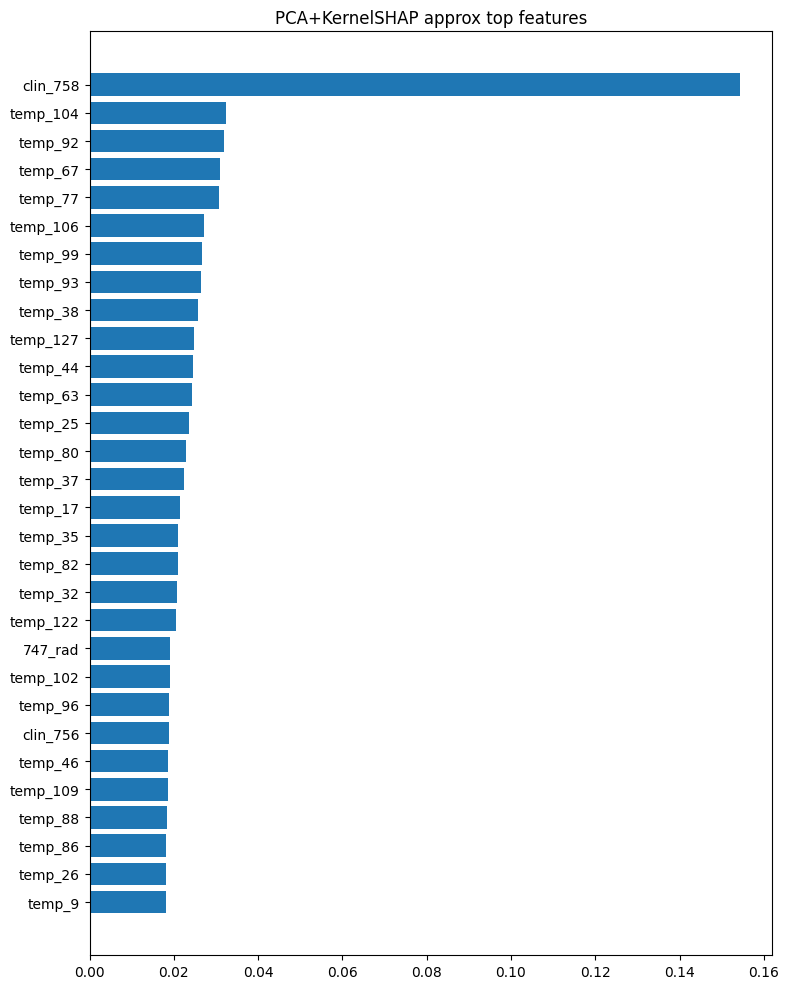

Saved PCA+SHAP artifacts.


In [19]:
# === PCA + Kernel SHAP fallback ===
import numpy as np, joblib, time, gc
from sklearn.decomposition import PCA
import shap

gc.collect()
X_train_concat = np.concatenate([X_train_static, X_train_temp, X_train_clin, X_train_rad], axis=1)
X_test_concat  = np.concatenate([X_test_static, X_test_temp, X_test_clin, X_test_rad], axis=1)
print("Orig dims:", X_train_concat.shape[1])

k = 50  # target PCA dims (adjust)
pca = PCA(n_components=k, random_state=SEED)
pca.fit(X_train_concat)
X_train_pca = pca.transform(X_train_concat)
X_test_pca  = pca.transform(X_test_concat)

# wrapper predict fn for PCA inputs
def predict_pca(x_pca):
    # x_pca: numpy (B,k) -> reconstruct to orig dims (approx) and predict
    X_approx = pca.inverse_transform(x_pca)
    return model_predict_np(X_approx)  # reuses earlier model_predict_np wrapper (must exist)

# KernelExplainer on PCA space (smaller)
bg_size = min(50, X_train_pca.shape[0])
sample_size = min(50, X_test_pca.shape[0])
rng = np.random.RandomState(SEED)
bg_idx = rng.choice(X_train_pca.shape[0], bg_size, replace=False)
sample_idx = rng.choice(X_test_pca.shape[0], sample_size, replace=False)
bg = X_train_pca[bg_idx]
X_explain_pca = X_test_pca[sample_idx]

explainer = shap.KernelExplainer(predict_pca, bg)
shap_vals_pca = explainer.shap_values(X_explain_pca, nsamples=200)  # adjust nsamples as needed
shap_vals_pca = np.array(shap_vals_pca)
print("PCA-SHAP done shape:", shap_vals_pca.shape)

# Map PCA feature importances back to original dimensions by multiplying PCA components
# mean_abs in PCA space
mean_abs_pca = np.mean(np.abs(shap_vals_pca), axis=0)
# importance per original feature approx = sum_j |mean_abs_pca_j * |pca.components_[j, i]||
orig_imp = np.sum(np.abs(mean_abs_pca[:, None] * pca.components_), axis=0)
# get top original features
idx_top = np.argsort(-orig_imp)[:30]
feat_names_full = []
if len(numeric_static)>0: feat_names_full += numeric_static
if 'X_train_cat' in globals() and X_train_cat.shape[1]>0: feat_names_full += [f"cat_{i}" for i in range(X_train_cat.shape[1])]
feat_names_full += [f"temp_{i}" for i in range(X_train_temp.shape[1])]
feat_names_full += [f"clin_{i}" for i in range(X_train_clin.shape[1])]
feat_names_full += [f"rad_{i}" for i in range(X_train_rad.shape[1])]
if len(feat_names_full) != orig_imp.shape[0]:
    feat_names_full = [f"feat_{i}" for i in range(orig_imp.shape[0])]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,10))
plt.barh([feat_names_full[i] for i in idx_top[::-1]], orig_imp[idx_top][::-1])
plt.title("PCA+KernelSHAP approx top features")
plt.tight_layout()
plt.savefig(os.path.join(EXPLAIN_DIR, f"pca_shap_top30_{WINDOW}.png"), bbox_inches='tight')
plt.show()

# Save outputs
joblib.dump({'pca': pca, 'shap_vals_pca': shap_vals_pca, 'orig_imp': orig_imp, 'feat_names_full': feat_names_full}, os.path.join(EXPLAIN_DIR, f"pca_shap_{WINDOW}.pkl"))
print("Saved PCA+SHAP artifacts.")


In [20]:
# === Captum Integrated Gradients (recommended) ===
# Paste and run in the notebook. Installs captum if missing, then runs IG for a small sample.
import os, joblib, time, gc, numpy as np, traceback
import torch

try:
    import captum
    from captum.attr import IntegratedGradients
except Exception:
    print("Captum not found — installing captum...")
    !pip install captum --quiet
    import importlib
    importlib.reload(torch)
    from captum.attr import IntegratedGradients

gc.collect()
torch.cuda.empty_cache()

# dims
s_dim = X_train_static.shape[1]
t_dim = X_train_temp.shape[1]
c_dim = X_train_clin.shape[1]
r_dim = X_train_rad.shape[1]
D_concat = s_dim + t_dim + c_dim + r_dim
print("Concatenated feature dim:", D_concat)

# Wrapper model: accepts concatenated tensor (B,D) and returns scalar probs (B,)
model.to(DEVICE)
model.eval()

def model_forward_concat_tensor(x_concat):
    """
    x_concat: torch tensor (B, D_concat)
    returns: torch.tensor (B,) probabilities
    """
    # split
    s = x_concat[:, :s_dim]
    t = x_concat[:, s_dim:s_dim+t_dim]
    c = x_concat[:, s_dim+t_dim:s_dim+t_dim+c_dim]
    r = x_concat[:, s_dim+t_dim+c_dim:]
    logits, _ = model(s.to(DEVICE), t.to(DEVICE), c.to(DEVICE), r.to(DEVICE))
    return torch.sigmoid(logits)

# Prepare background and explain samples (small)
bg_size = min(30, X_train_static.shape[0])
sample_size = min(20, X_test_static.shape[0])
rng = np.random.RandomState(SEED if 'SEED' in globals() else 42)
bg_idx = rng.choice(X_train_static.shape[0], bg_size, replace=False)
sample_idx = rng.choice(X_test_static.shape[0], sample_size, replace=False)

# Build concatenated numpy arrays
X_train_concat = np.concatenate([X_train_static, X_train_temp, X_train_clin, X_train_rad], axis=1)
X_test_concat  = np.concatenate([X_test_static, X_test_temp, X_test_clin, X_test_rad], axis=1)

bg = torch.tensor(X_train_concat[bg_idx], dtype=torch.float32).to(DEVICE)
X_explain = torch.tensor(X_test_concat[sample_idx], dtype=torch.float32).to(DEVICE)

print("BG shape:", bg.shape, "Explain shape:", X_explain.shape)

# initialize IG
ig = IntegratedGradients(model_forward_concat_tensor)

# compute attributions (approx) per sample with baseline = background mean
baseline = bg.mean(dim=0, keepdim=True)  # (1,D)
attributions = []
start = time.time()
for i in range(X_explain.shape[0]):
    x = X_explain[i:i+1]
    try:
        attr = ig.attribute(x, baselines=baseline, n_steps=50, internal_batch_size=1)
        attributions.append(attr.detach().cpu().numpy().reshape(-1))
    except Exception as e:
        print("IG failed for sample", i, "error:", e)
        attributions.append(np.zeros((D_concat,), dtype=float))
print("IG time (s):", time.time()-start)

attributions = np.stack(attributions, axis=0)  # (sample_count, D)
# aggregate mean absolute
mean_abs = np.mean(np.abs(attributions), axis=0)
# feature names
feat_names = []
if len(numeric_static)>0: feat_names += numeric_static
if 'X_train_cat' in globals() and X_train_cat.shape[1]>0:
    feat_names += [f"cat_{i}" for i in range(X_train_cat.shape[1])]
feat_names += [f"temp_{i}" for i in range(t_dim)]
feat_names += [f"clin_{i}" for i in range(c_dim)]
feat_names += [f"rad_{i}" for i in range(r_dim)]
if len(feat_names) != D_concat:
    feat_names = [f"feat_{i}" for i in range(D_concat)]

# Save outputs
outpath = os.path.join(EXPLAIN_DIR, f"captum_ig_{WINDOW}.pkl")
joblib.dump({'attributions': attributions, 'mean_abs': mean_abs, 'feat_names': feat_names, 'sample_idx': sample_idx}, outpath)
print("Saved Captum IG outputs to:", outpath)

# Plot topk
topk = min(30, len(mean_abs))
idxs = np.argsort(-mean_abs)[:topk]
import matplotlib.pyplot as plt
plt.figure(figsize=(8, max(4, topk*0.22)))
plt.barh([feat_names[i] for i in idxs[::-1]], mean_abs[idxs][::-1])
plt.title("Top mean |IntegratedGradients|")
plt.tight_layout()
plt.savefig(os.path.join(EXPLAIN_DIR, f"captum_ig_top{topk}_{WINDOW}.png"), bbox_inches='tight')
plt.show()
print("Done.")


Captum not found — installing captum...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s e

RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace triton; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:2623; latest registration was registered at /dev/null:2623